# Visualization of the Social Network and the Cascade Network

In [1]:
import os
import scipy.io
import numpy as np
import sys
from pathlib import Path
# from nbconvert.preprocessors import ExecutePreprocessor
# import nbformat
import pickle
import time
import matplotlib.pyplot as plt
import networkx as nx
# import pymnet
%pip install ipympl
%matplotlib widget
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.path import Path


PYDEVD_DISABLE_FILE_VALIDATION=1

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/easy_tpp-0.1.0-py3.13.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from bi_layer_NetViz_fcts import *

In [3]:
# load the parameters from the dictionary
with open(os.getcwd()+'/example/url_params.pkl', 'rb') as f:
    dict_url = pickle.load(f)

In [4]:
# Set the parameters
N1 = dict_url['N1']
N2 = dict_url['N2']
adj_g1 = dict_url['adj_g1']
adj_g2 = dict_url['adj_g2']
num_eve_g1_g2 = dict_url['num_eve_g1_g2']
cross_g1_g2 = dict_url['cross_g1_g2']
exp_coeff = dict_url['exp_coeff']
hours = dict_url['hours']

In [16]:
if __name__ == '__main__':

    # define graphs
    h = nx.from_numpy_array(adj_g2)
    g = nx.from_numpy_array(adj_g1)


    # Create separate labels for nodes 0 and 1 in both layers
    node_labels_g2 = {nn: str(nn) for nn in range(N2)}
    node_labels_g1 = {nn: ' ' for nn in range(N1)}


    # Combine the labels
    node_labels = [node_labels_g2, node_labels_g1]

    # node sizes
    num_eve_g2 = np.sum(num_eve_g1_g2, axis=0)
    num_eve_g1 = np.sum(num_eve_g1_g2, axis=1)
    # node_sizes = [num_eve_p**0.8,num_eve_u
    node_sizes = [num_eve_g2**0.8,num_eve_g1**0.9]

    # node pairs
    k = 1
    if k>0:
        top_k_g1_indices_g2 = np.zeros((N2, k), dtype=int)
        # for each product
        for i in range(N2):
            # Get the indices of the top k mu_u^p with the largest values for each cascade
            top_k_g1_indices_g2[i] = np.argsort(cross_g1_g2[:, i])[-k:][::-1]

        node_pair = [(i, j) for i in range(N2) for j in top_k_g1_indices_g2[i]]
    else:
        node_pair = None

    # nodes in g1 are related to g2 according to a categorical distribution
    alignment_g1_g2 = np.exp(exp_coeff*num_eve_g1_g2@adj_g2/hours)/np.sum(np.exp(exp_coeff*num_eve_g1_g2@adj_g2/hours),axis=1)[:,None]

    # node coloring
    N1_colors, N2_colors = compute_node_colors(alignment_g1_g2)
    node_colors = [N2_colors, N1_colors]



    # define layouts
    # Positions
    seed = np.random.randint(0, 1000)#304
    print("used seed:", seed)

    layout_g2 = nx.spring_layout(nx.from_numpy_array(adj_g2), scale = 1,seed=seed)
    lay_g2_array = np.array([layout_g2[key] for key in range(N2)])
    g1_pos = np.dot(alignment_g1_g2, lay_g2_array)

    #mix with spring layout_u
    layout_g1 = nx.spring_layout(nx.from_numpy_array(adj_g1), scale=1,seed=seed)
    lay_g1_array = np.array([layout_g1[key] for key in range(N1)])
    alpha = 0.7 # convex combination of both layouts, can be tuned
    g1_positions = alpha*g1_pos + (1-alpha)*lay_g1_array
    layout_g2 = lambda x: {i: lay_g2_array[i] for i in range(N2)} #nx.spring_layout
    layout_g1 = lambda x: {i: g1_positions[i] for i in range(N1)} #nx.spring_layout
    layouts = [layout_g2, layout_g1]

    # node markers
    node_markers = [marker, ellipse_marker]

    #layer labels
    layer_labels = [[r'', r'$\mathbf{Topics (\Sigma)}$'], [r'', r'$\mathbf{Users (W)}$']]

    #edge labels
    edge_labels_g2 = {}
    for p1 in range(N2):
        for p2 in range(N2):
            if p1!=p2 and adj_g2[p1,p2]>1e-1:
                edge_labels_g2[(p1,p2)] = fr'{adj_g2[p1,p2]}'

    #edge labels
    edge_labels_g1 = {}
    for u1 in range(N1):
        for u2 in range(N1):
            if u1!=u2 and adj_g1[u1,u2]>=1e-4:
                edge_labels_g1[(u1,u2)] = fr'{adj_g1[u1,u2]}'

    edge_labels = [edge_labels_g2, {}]

used seed: 279


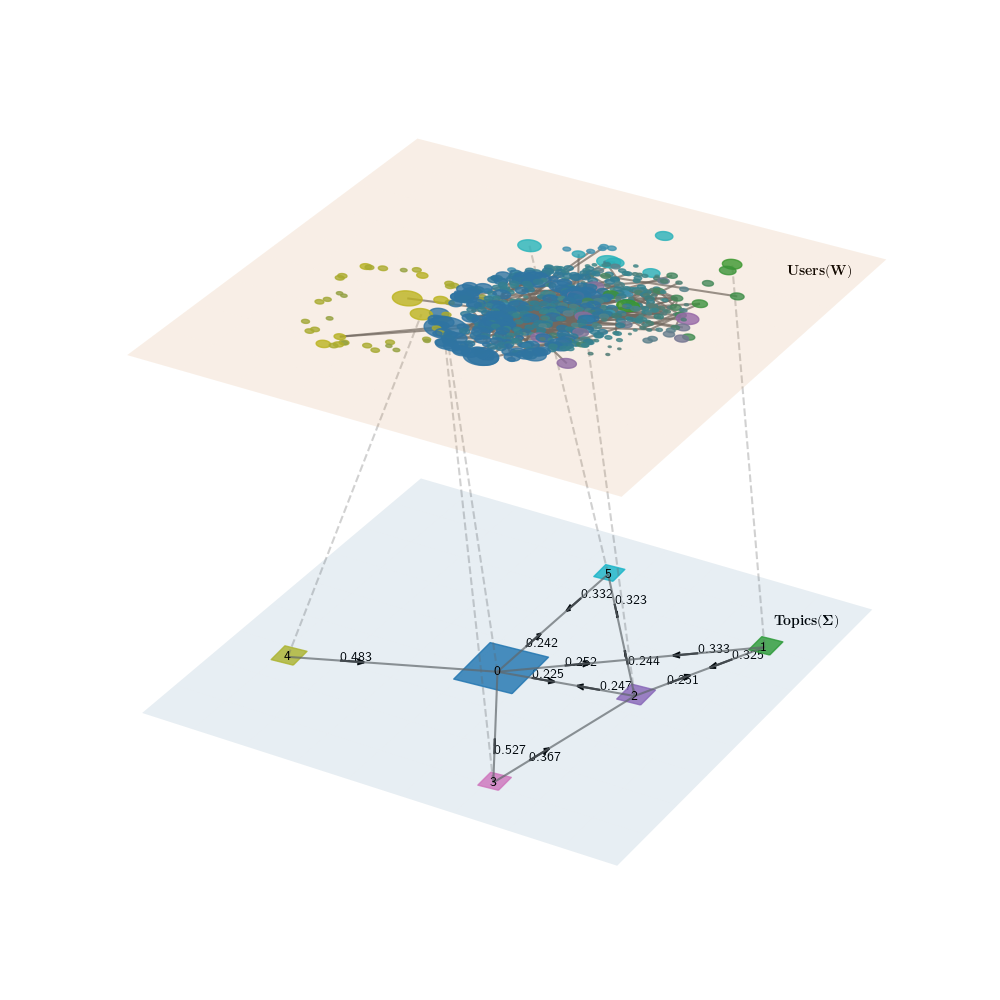

In [18]:
# initialise figure and plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
LayeredNetworkGraph([h, g], node_pairs=node_pair, node_color=node_colors,
                    node_sizes=node_sizes, node_labels=node_labels,node_markers=node_markers,
                        layer_labels=layer_labels,edge_labels=edge_labels, ax=ax, layouts=layouts)
ax.set_axis_off()
plt.tight_layout()
plt.show()